In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split

In [4]:
df = pd.read_csv('transformed.csv', index_col=0)

In [5]:
df.head()

,gender,age,country,education_level,undergrad_major,role,employer_industry,years_experience,yearly_compensation
2,Male,30-34,Indonesia,Bachelor’s degree,Engineering (non-computer focused),Other,Manufacturing/Fabrication,5-10,"10-20,000"
3,Female,30-34,United States of America,Master’s degree,"Computer science (software engineering, etc.)",Data Scientist,I am a student,0-1,"0-10,000"
5,Male,22-24,India,Master’s degree,Mathematics or statistics,Data Analyst,I am a student,0-1,"0-10,000"
7,Male,35-39,Chile,Doctoral degree,"Information technology, networking, or system ...",Other,Academics/Education,10-15,"10-20,000"
8,Male,18-21,India,Master’s degree,"Information technology, networking, or system ...",Other,Other,0-1,"0-10,000"


In [20]:
df_tf = pd.get_dummies(df[[c for c in df.columns if c != 'yearly_compensation']], dummy_na=True)
df_tf.shape

(12956, 149)

In [9]:
target = df['yearly_compensation']

In [24]:
from pandas.api.types import CategoricalDtype

# transforming compensation into category type and ordening the values
categ = ['0-10,000', '10-20,000', '20-30,000', '30-40,000', '40-50,000',
         '50-60,000', '60-70,000', '70-80,000', '80-90,000', '90-100,000',
         '100-125,000', '125-150,000', '150-200,000', '200-250,000', '250-300,000',
         '300-400,000', '400-500,000', '500,000+']
cat_type = CategoricalDtype(categories=categ, ordered=True)
target = target.astype(cat_type)

In [25]:
from sklearn.model_selection import train_test_split
train_X, test_X, train_y, test_y = train_test_split(df_tf, target, test_size=.25, random_state=42)

In [42]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import tqdm

In [309]:
models = []
for i, cat in tqdm.tqdm(enumerate(target.cat.categories[:-1])):
#     print(i, cat, categ[:i + 1], categ[i + 1:])
    labels = [0] * len(categ[:i+1]) + [1] * len(categ[i + 1:])
    map = {cat: labels[j] for j, cat in enumerate(categ)}
    new_target = train_y.replace(map)
    mod = LogisticRegression(random_state=42, solver='lbfgs')
    mod.fit(train_X, new_target)
    models.append(mod)

0it [00:00, ?it/s]/home/ptyshevskyi/envs/loc_env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
1it [00:01,  1.31s/it]/home/ptyshevskyi/envs/loc_env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
3it [00:03,  1.28s/it]/home/ptyshevskyi/envs/loc_env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
4it [00:05,  1.27s/it]/home/ptyshevskyi/envs/loc_env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
5it [00:06,  1.33s/it]/home/ptyshevskyi/envs

In [272]:
# models = []
# for i, cat in tqdm.tqdm(enumerate(target.cat.categories[:-1])):
# #     print(i, cat, categ[:i + 1], categ[i + 1:])
#     labels = [0] * len(categ[:i+1]) + [1] * len(categ[i + 1:])
#     map = {cat: labels[j] for j, cat in enumerate(categ)}
#     new_target = train_y.replace(map)
#     mod = RandomForestClassifier(random_state=42, n_estimators=100)
#     mod.fit(train_X, new_target)
#     models.append(mod)

17it [00:32,  1.23s/it]


In [310]:
test_y.values[0]

'50-60,000'

In [311]:
single_example = test_X.iloc[0, :]
single_example = single_example.values.reshape(1, -1)

In [312]:
binary_probabilities = [mod.predict_proba(single_example) for mod in models]

In [313]:
neg_probs = [p[0][0] for p in binary_probabilities]
pos_probs = [p[0][1] for p in binary_probabilities]

In [314]:
from functools import reduce
prod = lambda x, y: x * y

In [316]:
bin_probabilities = []
for i in range(len(models)):
    bin_prob = [p for p in pos_probs[:i]] + [neg_probs[i]]
#     print(bin_prob)
    reduced = reduce(prod, bin_prob)
    bin_probabilities.append(reduced)
bin_probabilities.append(reduce(prod, pos_probs))

In [288]:
import numpy as np

In [341]:
def seq_predict_sample(sample, models):
    """
    Given list of binary classifiers and a sample, predict the most probable category index and the distribution
    """
    binary_probabilities = [mod.predict_proba(sample) for mod in models]
    neg_probs = [p[0][0] for p in binary_probabilities]
    pos_probs = [p[0][1] for p in binary_probabilities]
    bin_probabilities = []
    for i in range(len(models)):
        bin_prob = [p for p in pos_probs[:i]] + [neg_probs[i]]
        reduced = reduce(prod, bin_prob)
        bin_probabilities.append(reduced)
    bin_probabilities.append(reduce(prod, pos_probs))
    return np.argmax(bin_probabilities), bin_probabilities

In [342]:
def predict_multimodel(X):
    """
    Predict value using sequential binary classification
    """
    y_pred = []
    for i, row in tqdm.tqdm(X.iterrows()):
        y_idx, _ = seq_predict_sample(row.values.reshape(1, -1), models)
        y_pred.append(categ[y_idx])
    return y_pred

In [343]:
y_pred = predict_multimodel(test_X)

3239it [00:06, 521.39it/s]


In [345]:
accuracy_score(test_y, y_pred)

0.37202840382834207

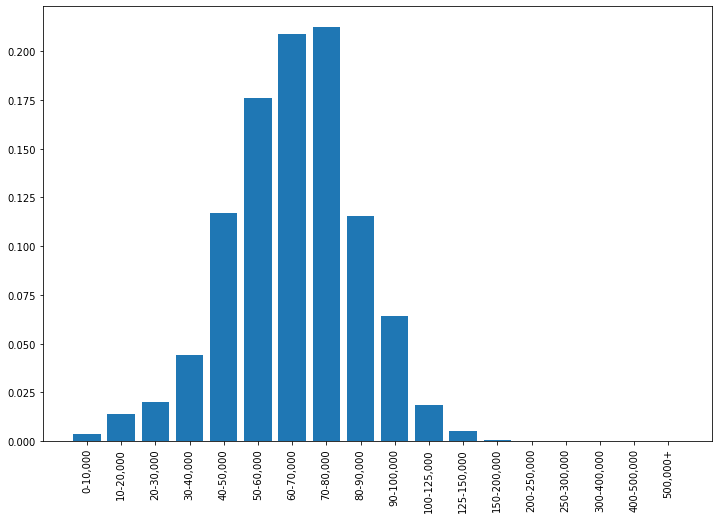

In [319]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 8))
plt.xticks(rotation=90);
plt.bar(categ, bin_probabilities);

In [237]:
lr = LogisticRegression(solver='lbfgs', random_state=42, multi_class='auto')
lr.fit(train_X, train_y)

In [320]:
lr.predict_proba(single_example)

array([[8.09552389e-04, 1.18237266e-02, 4.88756958e-02, 1.01915840e-01,
        1.49927391e-01, 1.26077538e-02, 1.13855045e-02, 1.02367503e-03,
        4.04843781e-02, 3.29378088e-03, 1.16743852e-01, 1.58351239e-04,
        9.04174213e-02, 7.29382688e-05, 1.05268399e-01, 1.43155995e-01,
        4.13953206e-02, 1.20640425e-01]])

In [321]:
lr.classes_

array(['0-10,000', '10-20,000', '100-125,000', '125-150,000',
       '150-200,000', '20-30,000', '200-250,000', '250-300,000',
       '30-40,000', '300-400,000', '40-50,000', '400-500,000',
       '50-60,000', '500,000+', '60-70,000', '70-80,000', '80-90,000',
       '90-100,000'], dtype=object)

In [322]:
lr_probs = lr.predict_proba(single_example)

In [323]:
sorted_probs = [lr_probs[0][list(lr.classes_).index(c)] for c in categ]

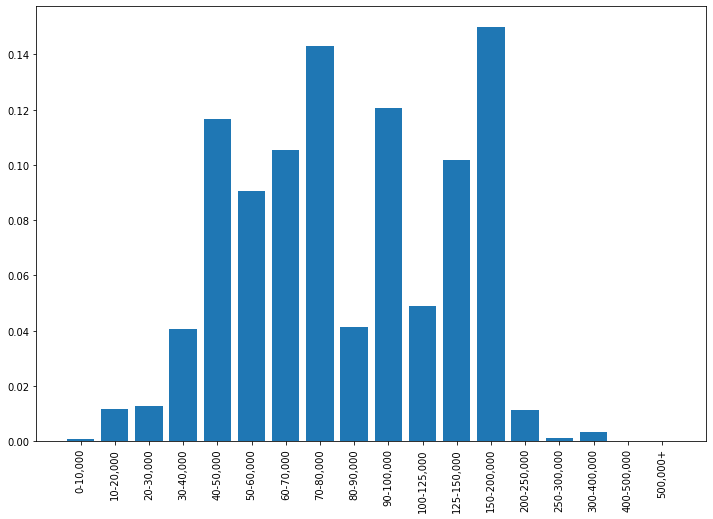

In [324]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 8))
plt.xticks(rotation=90);
plt.bar(categ, sorted_probs);

In [249]:
## Check the perfomance
from sklearn.metrics import accuracy_score
accuracy_score(test_y, lr.predict(test_X))

0.366471133065761

In [251]:
acc

,gender_Female,gender_Male,gender_nan,age_18-21,age_22-24,age_25-29,age_30-34,age_35-39,age_40-44,age_45-49,...,years_experience_1-2,years_experience_10-15,years_experience_15-20,years_experience_2-3,years_experience_20-25,years_experience_25-30,years_experience_3-4,years_experience_4-5,years_experience_5-10,years_experience_nan
4263,0,1,0,0,0,0,0,0,1,0,...,1,0,0,0,0,0,0,0,0,0
16986,0,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
485,0,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6367,1,0,0,0,0,0,0,1,0,0,...,0,1,0,0,0,0,0,0,0,0
14521,0,1,0,1,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
22978,0,1,0,1,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4577,0,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
5831,0,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1172,0,1,0,0,1,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
7872,0,1,0,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


[0.586068808301321,
 0.8305710089983029,
 0.9244058209027496,
 0.9503867891405675,
 0.959798891143155,
 0.9729759077521815,
 0.9766449332093493,
 0.9790643209730348,
 0.9827485012526916,
 0.986533718925159,
 0.9909277916034878,
 0.9906433577975438,
 0.9895720648515497,
 0.9946745530034252,
 0.9978140996443656,
 0.9989402771681419,
 0.9992888176860782]